In [102]:
import librosa
import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm
from sklearn.decomposition import NMF
import torch
import torch.nn.functional as F
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, TimeDistributed, GRU, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [2]:
def extract_scaled_melspec(y, sr, n_fft=2048, hop_length=512, n_mels=128):
    """Extracts a Mel-spectrogram from an audio signal."""
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    min_val = np.min(S_dB)
    max_val = np.max(S_dB)
    scaled_melspec = (S_dB - min_val) / (max_val - min_val)
    return scaled_melspec


def decompose_spectrogram_with_nmf(scaled_spectrogram, n_components):
    """Decomposes a scaled Mel-spectrogram using NMF from sklearn, without sorting the components."""
    # Initialize the NMF model with the specified max_iter
    model = NMF(n_components=n_components, max_iter=1500, init='nndsvd', random_state=0)
    
    # Fit the model to the transposed spectrogram (samples x features)
    # Note: sklearn expects features as columns, hence the transpose
    V = scaled_spectrogram.T
    W = model.fit_transform(V)  # W corresponds to the code (activation matrix)
    H = model.components_       # H corresponds to the components (dictionary matrix)
    
    # Return the components, code, and the reconstruction without sorting the components
    return H, W


def create_measure_grid(onset_frames, sr, beat_interval_in_frames, time_signature, duration):
    """Creates a grid of measures based on the tempo, time signature, and beats of the song."""

    tolerance_in_seconds = 0.1
    tolerance_in_frames = int(librosa.time_to_frames(tolerance_in_seconds, sr=sr))

    # Convert duration from seconds to frames
    duration_in_frames = librosa.time_to_frames(duration, sr=sr)

    # Find valid beat sequences
    valid_sequences = []
    current_sequence = []
    min_sequence_length = 4
    for i in range(len(onset_frames) - 1):
        frame_diff = onset_frames[i + 1] - onset_frames[i]
        if abs(frame_diff - beat_interval_in_frames) <= tolerance_in_frames:
            if not current_sequence:
                current_sequence = [onset_frames[i]]
            current_sequence.append(onset_frames[i + 1])
        else:
            if current_sequence and len(current_sequence) >= min_sequence_length:
                valid_sequences.append(current_sequence)
            current_sequence = []
    if current_sequence and len(current_sequence) >= min_sequence_length:
        valid_sequences.append(current_sequence)

    # If no valid sequences are found, start a grid search
    while not valid_sequences and tolerance_in_seconds < 0.5 and min_sequence_length > 1:
        tolerance_in_seconds += 0.1
        tolerance_in_frames = int(librosa.time_to_frames(tolerance_in_seconds, sr=sr))
        min_sequence_length -= 1
        valid_sequences = []
        current_sequence = []
        for i in range(len(onset_frames) - 1):
            frame_diff = onset_frames[i + 1] - onset_frames[i]
            if abs(frame_diff - beat_interval_in_frames) <= tolerance_in_frames:
                if not current_sequence:
                    current_sequence = [onset_frames[i]]
                current_sequence.append(onset_frames[i + 1])
            else:
                if current_sequence and len(current_sequence) >= min_sequence_length:
                    valid_sequences.append(current_sequence)
                current_sequence = []
        if current_sequence and len(current_sequence) >= min_sequence_length:
            valid_sequences.append(current_sequence)

    # Set the anchor frame to the first onset if no valid sequences are found
    if not valid_sequences:
        anchor_frame = onset_frames[0]
    else:
        first_sequence = valid_sequences[0]
        anchor_frame = first_sequence[0]

    # Add beats before the first onset (working backwards)
    beat_grid = [anchor_frame]
    current_frame = anchor_frame
    while current_frame >= 0:
        current_frame -= beat_interval_in_frames
        beat_grid.insert(0, current_frame)

    # Remove the first beat if it's negative
    if beat_grid[0] < 0:
        beat_grid.pop(0)

    # Group beats into measures
    measures = []
    current_frame = beat_grid[0]
    while current_frame <= duration_in_frames:
        measures.append(current_frame)
        current_frame += beat_interval_in_frames * time_signature
    # Insert 0 if not already in the list
    if measures[0] != 0:
        measures.insert(0, 0)
    
    # Append the duration if not already in the list
    if measures[-1] != duration_in_frames:
        measures.append(duration_in_frames)
    
    return np.array(measures)


def find_anchor_frame(beats, tempo, sr):
    # Convert tempo to interval in seconds between beats
    seconds_per_beat = 60.0 / tempo
    
    # Convert interval to expected frames between beats
    expected_interval = int(librosa.time_to_frames(seconds_per_beat, sr=sr))
    
    # Calculate the difference between consecutive beats
    beat_intervals = np.diff(beats)
    
    # Initialize variables to keep track of the best matching sequence
    best_match_start = None
    best_match_quality = 0
    
    # Sliding window size based on a small multiplier of the expected interval to capture tempo variations
    window_size = 3  # Small window to check consistency of intervals
    
    # Iterate through beat intervals with a sliding window
    for i in range(len(beat_intervals) - window_size + 1):
        window = beat_intervals[i:i+window_size]
        
        # Calculate the average interval in the current window and its match quality
        avg_interval = np.mean(window)
        match_quality = 1 - abs(avg_interval - expected_interval) / expected_interval
        
        # Update the best match if this window represents a higher quality match
        if match_quality > best_match_quality:
            best_match_start = beats[i]
            best_match_quality = match_quality
            
            # Early exit condition if the match quality is high enough
            if match_quality > 0.95:
                return best_match_start
    
    return best_match_start


def create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, duration):
    """Creates a grid of measures based on the tempo, time signature, and beats of the song."""
    duration_in_frames = int(librosa.time_to_frames(duration, sr=sr))
    
    if not anchor_frame:
        anchor_frame = beats[0]

    # Add beats before the first onset (working backwards)
    beat_grid = [anchor_frame]
    current_frame = anchor_frame
    while current_frame >= 0:
        current_frame -= beat_interval_in_frames
        beat_grid.insert(0, current_frame)

    # Remove the first beat if it's negative
    if beat_grid[0] < 0:
        beat_grid.pop(0)
        
    # Group beats into measures
    measure_grid = []
    current_frame = beat_grid[0]
    while current_frame <= duration_in_frames:
        measure_grid.append(current_frame)
        current_frame += beat_interval_in_frames * time_signature

    # Insert 0 if not already in the list
    if measure_grid[0] != 0:
        measure_grid.insert(0, 0)
    
    # Append the duration if not already in the list
    if measure_grid[-1] != duration_in_frames:
        measure_grid.append(duration_in_frames)
    
    return np.array(beat_grid), np.array(measure_grid)


def generate_and_align_labels(df, n_frames, measure_grid_frames):
    """Generates a binary sequence of labels (1 for 'chorus', 0 for 'other') for each frame in a song,
    and aligns the label sequence with the measure grid by labeling a measure as 'chorus' if at least
    1/4 of the frames within the measure are labeled as 'chorus'.
    """
    # Generate binary label sequence
    binary_label_sequence = np.zeros(n_frames, dtype=int)
    for index, row in df.iterrows():
        start_frame = row['start_frame']
        end_frame = row['end_frame']
        if row['label'] == 'chorus':
            binary_label_sequence[start_frame:end_frame] = 1

    # Initialize the aligned_labels array
    aligned_labels = np.zeros(len(measure_grid_frames) - 1, dtype=int)

    # Iterate over each measure
    for i in range(len(measure_grid_frames) - 1):
        start_frame = measure_grid_frames[i]
        end_frame = measure_grid_frames[i + 1]

        # Extract the labels for the current measure
        measure_labels = binary_label_sequence[start_frame:end_frame]

        # Calculate the proportion of '1' labels in the current measure
        proportion_of_ones = np.sum(measure_labels) / len(measure_labels)

        # If at least 1/4 of the measure is labeled as 'chorus', set the measure label to '1'
        if proportion_of_ones >= 0.25:
            aligned_labels[i] = 1
        else:
            aligned_labels[i] = 0

    return aligned_labels


def segment_data_measures(data, measure_grid_frames):
    segments = []
    for i in range(len(measure_grid_frames) - 1):
        start_frame = measure_grid_frames[i]
        end_frame = measure_grid_frames[i + 1]
        segment = data[start_frame:end_frame]
        segments.append(segment)
    return segments


def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # Apply sin to even indices in the array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # Apply cos to odd indices in the array
    pos_encoding = angle_rads[np.newaxis, ...]
    return pos_encoding


def apply_positional_encoding(segments):
    num_frames_per_measure, n_components = segments[0].shape
    num_measures = len(segments)
    # Generate positional encodings for all frames
    max_position = num_measures * num_frames_per_measure
    pos_encodings = positional_encoding(max_position, n_components)
    # Apply positional encoding to each segment
    encoded = []
    for segment in segments:
        segment_length = segment.shape[0]
        # Ensure pos_encodings is 2D to match segment dimensions
        segment_pos_encoding = pos_encodings[0, :segment_length, :]  # Index into the first dimension to reduce it
        # Add positional encoding to the segment
        encoded.append(np.concatenate([segment, segment_pos_encoding], axis=-1))
    return encoded


def apply_hybrid_positional_encoding(segments):
    # Assume each segment is a measure and segments is a list of all measures in a song
    # Each segment's shape is [num_frames_per_measure, n_features]
    
    # Calculate the total number of measures
    num_measures = len(segments)
    # Assume all segments have the same number of frames for simplicity; adjust as needed
    num_frames_per_measure = segments[0].shape[0]
    n_features = segments[0].shape[1]
    
    # Generate measure-level positional encodings
    measure_level_encodings = positional_encoding(num_measures, n_features)
    
    # Generate frame-level positional encodings for a single measure
    # Assuming all measures have the same number of frames
    frame_level_encodings = positional_encoding(num_frames_per_measure, n_features)
    
    encoded_segments = []
    for i, segment in enumerate(segments):
        # Apply measure-level encoding to each frame in the measure
        measure_encoding = measure_level_encodings[0, i, :]
        
        # Apply frame-level encoding to the segment
        segment_with_frame_encoding = segment + frame_level_encodings[0, :, :]
        
        # Combine the two encodings by adding them. This is a simple way to combine
        # but other methods like concatenation could be considered depending on the model architecture
        combined_encoding = segment_with_frame_encoding + measure_encoding
        
        encoded_segments.append(combined_encoding)
    
    return encoded_segments


def pad_segments(segments, segment_length_frames):
    """Pads each segment to ensure uniformity in the number of frames per measure, using -1 for padding."""
    padded_segments = []
    for i, segment in enumerate(segments):
        pad_width = max(0, segment_length_frames - len(segment))
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left
        if i == 0 or i == len(segments) - 1:
            # Pad both sides for the first and last segments with -1
            padded_segment = np.pad(segment, ((pad_left, pad_right), (0, 0)), mode='constant', constant_values=-1)
        else:
            # Pad only the right side for other segments with -1
            padded_segment = np.pad(segment, ((0, pad_width), (0, 0)), mode='constant', constant_values=-1)
        padded_segments.append(padded_segment)
    return padded_segments

In [ ]:
# Load the DataFrame with labeled data
df = pd.read_csv('../data/dataframes/clean_labeled.csv')

segment_dir = "../data/pkl/segments"
labels_dir = "../data/pkl/labels"
os.makedirs(segment_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Iterate through the DataFrame and prepare data for each song
for _, group in tqdm(df.groupby('SongID'), desc='Processing'):
    song_id = group['SongID'].values[0]
    audio_path = group['FilePath'].values[0]
    y, sr = librosa.load(audio_path, sr=None)

    # Extract & scale Mel-Spectrogram
    scaled_spectrogram = extract_scaled_melspec(y, sr)

    # Decompose spectrogram
    _, H = decompose_spectrogram_with_nmf(scaled_spectrogram, n_components=16)

    # Extract tempo, beat frames, and time signature
    C = np.abs(librosa.cqt(y=y, sr=sr))
    onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    bpm = group['sp_tempo'].values[0] if not pd.isna(group['sp_tempo'].values[0]) else tempo
    if bpm == 0:
        bpm = tempo
    if bpm > 140:
        bpm /= 2
    if bpm <= 70:
        bpm *= 2

    time_signature = group['sp_time_signature'].values[0] if not pd.isna(group['sp_time_signature'].values[0]) else 4
    time_signature = int(time_signature) if time_signature != 0 else 4

    # Create a measure grid
    duration = librosa.frames_to_time(len(spectrogram.T), sr=sr, hop_length=512)
    beat_interval_in_seconds = 60 / bpm
    beat_interval_in_frames = int(librosa.time_to_frames(beat_interval_in_seconds, sr=sr))
    measure_interval_in_frames = beat_interval_in_frames * time_signature
    anchor_frame = find_anchor_frame(beats, bpm, sr)
    beat_grid_frames, measure_grid_frames = create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, duration)

    
    # Generate label sequence
    n_frames = len(scaled_spectrogram[0])
    
    # Align and aggregate labels at the measure level
    aligned_labels = generate_and_align_labels(group, n_frames, measure_grid_frames)

    # Segment scaled Mel-spectrogram into measures
    segmented_H = segment_data_measures(H, measure_grid_frames)

    # Position encode
    encoded_H = apply_hybrid_positional_encoding(segmented_H)
    
    # Save segmented_H as a pickle file
    with open(os.path.join(segment_dir, f"{song_id}_encoded_H.pkl"), "wb") as f:
        pickle.dump(encoded_H, f)

    # Save aligned_labels as a pickle file
    with open(os.path.join(labels_dir, f"{song_id}_labels.pkl"), "wb") as f:
        pickle.dump(aligned_labels, f)

Processing:   0%|          | 0/332 [00:00<?, ?it/s]C:\Users\denni\anaconda3\envs\mixin\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1500 reached. Increase it to improve convergence.
  warnings.warn(
Processing:   1%|          | 2/332 [00:34<1:33:14, 16.95s/it]C:\Users\denni\anaconda3\envs\mixin\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1500 reached. Increase it to improve convergence.
  warnings.warn(
Processing:   2%|▏         | 5/332 [01:14<1:20:58, 14.86s/it]C:\Users\denni\anaconda3\envs\mixin\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1500 reached. Increase it to improve convergence.
  warnings.warn(
Processing:   4%|▍         | 14/332 [02:29<41:34,  7.84s/it] C:\Users\denni\anaconda3\envs\mixin\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1500 reac

## Load pickled data

In [3]:
def load_pickles_from_directory(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                all_data.append(data)
    return all_data

# Directories containing the pickled files
segment_dir = "../data/pkl/segments"
labels_dir = "../data/pkl/labels"

# Load all segments and labels
all_segments = load_pickles_from_directory(segment_dir)
all_labels = load_pickles_from_directory(labels_dir)

## Padding data and labels across entire dataset for input in convolutional layers in CRNN

In [16]:
def pad_all(all_segments, all_labels):
    # Find the maximum number of measures in any song
    max_measures = max(len(song) for song in all_segments)

    # Find the maximum number of frames per measure across all songs to standardize measure shape
    max_frames_per_measure = max(max(measure.shape[0] for measure in song) for song in all_segments)

    # Initialize new lists for padded segments and labels
    padded_segments = []
    padded_labels = []

    for song_idx, song in enumerate(all_segments):
        # Pad each song to have the same number of measures
        padded_song = []
        song_labels = all_labels[song_idx]  # Corresponding labels for the current song
        padded_song_labels = np.pad(song_labels, (0, max_measures - len(song)), mode='constant', constant_values=-1)  # Using -1 for padded label
        
        for measure in song:
            # Pad each measure in the song to have a uniform number of frames
            padded_measure = np.pad(measure, ((0, max_frames_per_measure - measure.shape[0]), (0, 0)), mode='constant', constant_values=-1)
            padded_song.append(padded_measure)
        
        # If the song has fewer measures than max_measures, pad the rest with -1 filled measures
        while len(padded_song) < max_measures:
            # Note: Adjust the shape and padding value as per your data structure, assuming 32 as feature dimension for example
            padded_measure = np.full((max_frames_per_measure, 32), -1)  # Assuming a measure shape that matches your data
            padded_song.append(padded_measure)
        
        padded_segments.append(padded_song)
        padded_labels.append(padded_song_labels)

    return padded_segments, padded_labels

## Generate batches so that each batch contains all the measures from a single song

In [96]:
# Convert the padded segments and labels into numpy arrays
segments_array = np.array(padded_segments)
labels_array = np.array(padded_labels)

# Get the number of songs, measures, and frames per measure
num_songs = segments_array.shape[0]
num_measures = segments_array.shape[1]
num_frames_per_measure = segments_array.shape[2]

# Create a list to store the batches
batches = []

# Group the measures of each song together
for i in range(num_songs):
    song_measures = segments_array[i]
    song_labels = labels_array[i]
    batches.append((song_measures, song_labels))

# Shuffle the batches 
np.random.shuffle(batches)

## Train/Validation/Test splits

In [107]:
# Split into train and test/validation sets
train_val_batches, test_batches = train_test_split(batches, test_size=0.2, random_state=42)

# Split the test/validation set into separate test and validation sets
test_batches, val_batches = train_test_split(test_batches, test_size=0.5, random_state=42)

# Extract the measures and labels from the train, test, and validation sets
train_measures, train_labels = zip(*train_val_batches)
test_measures, test_labels = zip(*test_batches)
val_measures, val_labels = zip(*val_batches)

# Convert the train, test, and validation sets into numpy arrays
X_train = np.array(train_measures)
y_train = np.array(train_labels)
X_test = np.array(test_measures)
y_test = np.array(test_labels)
X_val = np.array(val_measures)
y_val = np.array(val_labels)

## Initialize CRNN model

In [108]:
def masked_binary_crossentropy(y_true, y_pred):
    mask = tf.math.not_equal(y_true, -1)  # Create a mask for non-padded values
    masked_true = tf.boolean_mask(y_true, mask)  # Apply the mask to the true labels
    masked_pred = tf.boolean_mask(y_pred, mask)  # Apply the mask to the predicted labels
    loss = tf.keras.losses.binary_crossentropy(masked_true, masked_pred)  # Calculate the binary cross-entropy loss
    return loss
    
# Adjust the model definition to remove mask_zero argument in compile()
def build_crnn_model(input_shape, num_measures):
    model = tf.keras.Sequential([
        # Convolutional layers applied to each frame within measures independently
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'), input_shape=input_shape),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(2, 2)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(2, 2)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.GlobalAveragePooling2D()),

        # Recurrent layer that processes each measure and returns a sequence
        tf.keras.layers.GRU(64, return_sequences=True),

        # Output a binary prediction for each measure
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation='sigmoid')),
    ])
    
    # Compile the model with the custom loss function
    model.compile(loss=masked_binary_crossentropy, optimizer='adam', metrics=['accuracy'])
    return model

# Adjust input_shape and num_measures according to your data
num_measures = len(padded_segments[0])  # Number of measures to predict per segment
n_frames_per_measure = len(padded_segments[0][0])
input_shape = (num_measures, n_frames_per_measure, 32, 1)  # Example input shape
model = build_crnn_model(input_shape, num_measures)

# Summary of the model to verify the output shape
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_104 (TimeD  (None, 204, 298, 30, 16)  160      
 istributed)                                                     
                                                                 
 time_distributed_105 (TimeD  (None, 204, 149, 15, 16)  0        
 istributed)                                                     
                                                                 
 time_distributed_106 (TimeD  (None, 204, 147, 13, 32)  4640     
 istributed)                                                     
                                                                 
 time_distributed_107 (TimeD  (None, 204, 73, 6, 32)   0         
 istributed)                                                     
                                                                 
 time_distributed_108 (TimeD  (None, 204, 32)        

## Model training

In [109]:
# Callbacks for early stopping (to prevent overfitting) and for saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
]

history = model.fit(X_train, y_train, 
          batch_size=1, 
          epochs=10, 
          validation_data=(X_val, y_val),
          callbacks=callbacks)

Epoch 1/10
265/265 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.3086
Epoch 1: val_loss improved from inf to 0.68368, saving model to best_model.h5
265/265 [==============================] - 27s 96ms/step - loss: 0.6750 - accuracy: 0.3086 - val_loss: 0.6837 - val_accuracy: 0.2772
Epoch 2/10
265/265 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.3048
Epoch 2: val_loss improved from 0.68368 to 0.61058, saving model to best_model.h5
265/265 [==============================] - 25s 95ms/step - loss: 0.6626 - accuracy: 0.3048 - val_loss: 0.6106 - val_accuracy: 0.3028
Epoch 3/10
265/265 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.2958
Epoch 3: val_loss did not improve from 0.61058
265/265 [==============================] - 26s 96ms/step - loss: 0.6320 - accuracy: 0.2958 - val_loss: 0.6286 - val_accuracy: 0.3084
Epoch 4/10
265/265 [==============================] - ETA: 0s - loss: 0.6271 - accuracy: 0.2975
Epoch 4: v

## Model evaluation

In [111]:
custom_objects = {'masked_binary_crossentropy': masked_binary_crossentropy}

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5', custom_objects=custom_objects)

# Evaluate the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

2/2 [==============================] - 1s 34ms/step - loss: 0.6014 - accuracy: 0.3393
Test Loss: 0.6014370322227478
Test Accuracy: 0.3392750918865204


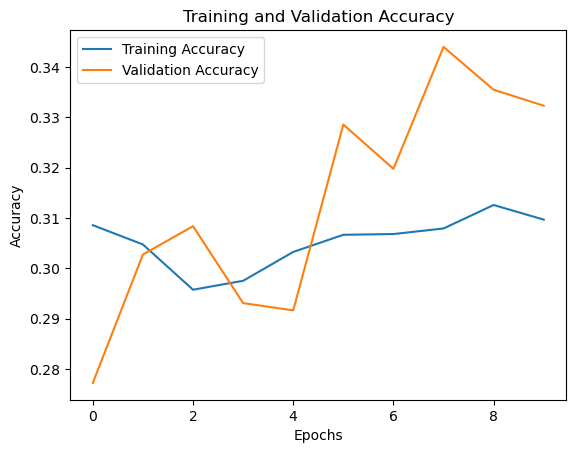

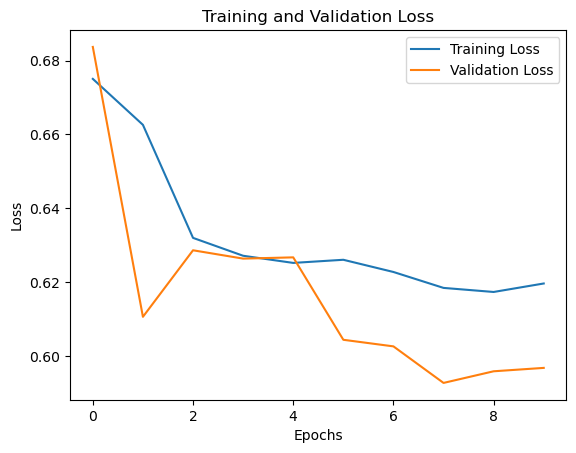

In [112]:
# Get the training and validation accuracy values from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy curves
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot the loss curves
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [113]:
song_id = 2
audio_path = '../data/audio_files/processed/2.mp3'
df = pd.read_csv('../data/dataframes/clean_labeled.csv')
df = df.loc[df["SongID"] == song_id]

y, sr = librosa.load(audio_path, sr=None)

# Extract Mel-spectrogram
spectrogram = extract_mel_spectrogram(y, sr)

# Scale Mel-spectrogram
scaled_spectrogram = scale_to_non_negative(spectrogram)

# Decompose spectrogram
_, H = decompose_spectrogram_with_nmf(scaled_spectrogram, n_components=16)

# Extract tempo, beat frames, and time signature
C = np.abs(librosa.cqt(y=y, sr=sr))
onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
tempo, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
sp_tempo = df['sp_tempo'].values[0] if not pd.isna(df['sp_tempo'].values[0]) else tempo
if sp_tempo == 0:
    sp_tempo = tempo
if sp_tempo > 150:
    sp_tempo /= 2
tempo = round_tempo(sp_tempo)

time_signature = df['sp_time_signature'].values[0] if not pd.isna(df['sp_time_signature'].values[0]) else 4
time_signature = int(time_signature) if time_signature != 0 else 4

# Create a measure grid
duration = librosa.frames_to_time(len(spectrogram.T), sr=sr, hop_length=512)
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr, backtrack=True, units='frames')
beat_interval_in_seconds = 60 / tempo
beat_interval_in_frames = int(librosa.time_to_frames(beat_interval_in_seconds, sr=sr))
measure_interval_in_frames = beat_interval_in_frames * time_signature
measure_grid_frames = create_measure_grid(onset_frames, sr, beat_interval_in_frames, time_signature, duration)

# Generate label sequence
n_frames = len(scaled_spectrogram[0])

# Align and aggregate labels at the measure level
aligned_labels = generate_and_align_labels(df, n_frames, measure_grid_frames)

# Segment scaled Mel-spectrogram into measures
segmented_H = segment_data_measures(H, measure_grid_frames)

# Pad spectrogram measures to have same length slices within each song
padded_H = pad_segments(segmented_H, measure_interval_in_frames)

# Position encode
encoded_H = apply_positional_encoding(padded_H)

In [117]:
len(encoded_H)

145